In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

df = pd.read_csv("data_FIXED.csv")

df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df.dropna(subset=['CustomerID', 'Description'])

basket = (df.groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().fillna(0))
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

frequent_items = apriori(basket, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_items, metric="lift", min_threshold=1)
rules.sort_values('lift', ascending=False, inplace=True)

print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

with open("association_rules.txt", "w", encoding="utf-8") as f:
    f.write(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].to_string())




/var/folders/y0/w82d1ghj7t7dybkpqfq69s8c0000gn/T/ipykernel_1491/422743813.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)
/Users/pyyan/Library/Python/3.9/lib/python/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


                                          antecedents  \
70  (roses regency teacup and saucer , green regen...   
75                   (pink regency teacup and saucer)   
71  (roses regency teacup and saucer , pink regenc...   
74                  (green regency teacup and saucer)   
8                   (green regency teacup and saucer)   
..                                                ...   
20                (jumbo shopper vintage red paisley)   
61                                   (spotty bunting)   
60                                    (party bunting)   
24                          (jumbo bag red retrospot)   
25                          (lunch bag red retrospot)   

                                          consequents   support  confidence  \
70                   (pink regency teacup and saucer)  0.021193    0.720887   
75  (roses regency teacup and saucer , green regen...  0.021193    0.701439   
71                  (green regency teacup and saucer)  0.021193    0.894495   

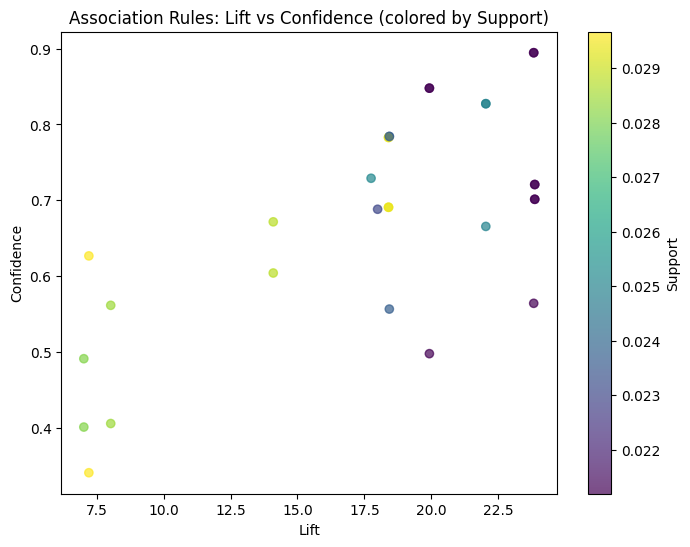

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(rules['lift'], rules['confidence'], c=rules['support'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Support')
plt.xlabel('Lift')
plt.ylabel('Confidence')
plt.title('Association Rules: Lift vs Confidence (colored by Support)')
plt.show()


In [6]:
top_rules = rules.sort_values('lift', ascending=False).head(10)
for _, r in top_rules.iterrows():
    print(f"{list(r['antecedents'])} → {list(r['consequents'])} | "
          f"support={r['support']:.3f}, confidence={r['confidence']:.3f}, lift={r['lift']:.2f}")


['roses regency teacup and saucer ', 'green regency teacup and saucer'] → ['pink regency teacup and saucer'] | support=0.021, confidence=0.721, lift=23.86
['pink regency teacup and saucer'] → ['roses regency teacup and saucer ', 'green regency teacup and saucer'] | support=0.021, confidence=0.701, lift=23.86
['roses regency teacup and saucer ', 'pink regency teacup and saucer'] → ['green regency teacup and saucer'] | support=0.021, confidence=0.894, lift=23.82
['green regency teacup and saucer'] → ['roses regency teacup and saucer ', 'pink regency teacup and saucer'] | support=0.021, confidence=0.564, lift=23.82
['green regency teacup and saucer'] → ['pink regency teacup and saucer'] | support=0.025, confidence=0.666, lift=22.03
['pink regency teacup and saucer'] → ['green regency teacup and saucer'] | support=0.025, confidence=0.827, lift=22.03
['roses regency teacup and saucer '] → ['green regency teacup and saucer', 'pink regency teacup and saucer'] | support=0.021, confidence=0.498

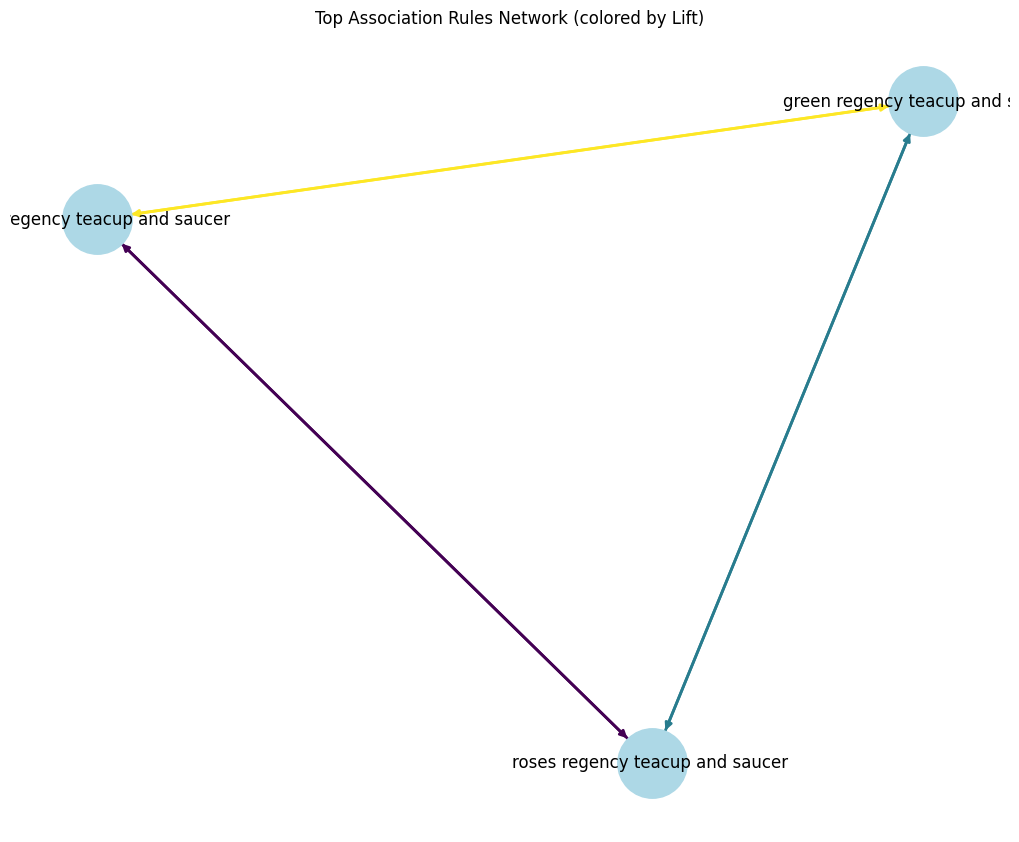

In [ ]:
import networkx as nx

G = nx.DiGraph()

for _, row in top_rules.iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            G.add_edge(a, c, weight=row['lift'])

plt.figure(figsize=(10,8))
pos = nx.spring_layout(G, k=0.3)
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=2500, edge_color=weights, edge_cmap=plt.cm.viridis, width=2)
plt.title('Top Association Rules Network (colored by Lift)')
plt.show()


#### Support $ \in (0, 1) $
$$
\text{Support}(A \Rightarrow B) = \frac{\text{Number of transactions containing both } A \text{ and } B}{\text{Total number of transactions}}
$$

#### Confidence $ \in (0, 1) $
$$
\text{Confidence}(A \Rightarrow B) = \frac{\text{Support}(A \cup B)}{\text{Support}(A)} = P(B|A)
$$

#### Lift $ \in (0, +\infty) $
$$
\text{Lift}(A \Rightarrow B) = \frac{\text{Confidence}(A \Rightarrow B)}{\text{Support}(B)} = \frac{P(A \cap B)}{P(A) \times P(B)}
$$

- $Support: 出现频率$
- $Confidence: 买了前者后，真的也买了后者的概率$
- $Lift: 买了后者的订单中，也买了前者的占比$


In [ ]:

top_support = rules.sort_values(by='support', ascending=False).head(10)

top_confidence = rules.sort_values(by='confidence', ascending=False).head(10)

top_lift = rules.sort_values(by='lift', ascending=False).head(10)

print("===== Top 10 by Support =====")
print(top_support[['antecedents', 'consequents', 'support', 'confidence', 'lift']], '\n')

print("===== Top 10 by Confidence =====")
print(top_confidence[['antecedents', 'consequents', 'support', 'confidence', 'lift']], '\n')

print("===== Top 10 by Lift =====")
print(top_lift[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


===== Top 10 by Support =====
                           antecedents                         consequents  \
17           (jumbo bag red retrospot)           (jumbo bag pink polkadot)   
16           (jumbo bag pink polkadot)           (jumbo bag red retrospot)   
12  (roses regency teacup and saucer )   (green regency teacup and saucer)   
13   (green regency teacup and saucer)  (roses regency teacup and saucer )   
0         (alarm clock bakelike green)         (alarm clock bakelike red )   
1          (alarm clock bakelike red )        (alarm clock bakelike green)   
46           (lunch bag pink polkadot)           (lunch bag red retrospot)   
47           (lunch bag red retrospot)           (lunch bag pink polkadot)   
31           (lunch bag red retrospot)            (lunch bag  black skull)   
30            (lunch bag  black skull)           (lunch bag red retrospot)   

     support  confidence       lift  
17  0.029671    0.341250   7.209739  
16  0.029671    0.626866   7.209739

In [9]:
import pandas as pd

def fs_to_str(x):
    try:
        if isinstance(x, str):
            return x
        return ', '.join(sorted(list(x)))
    except Exception:
        return str(x)

rules_export = rules.copy()
rules_export['antecedents_str'] = rules_export['antecedents'].apply(fs_to_str)
rules_export['consequents_str'] = rules_export['consequents'].apply(fs_to_str)

cols = ['antecedents_str', 'consequents_str', 'support', 'confidence', 'lift']
rules_export = rules_export[cols].rename(columns={
    'antecedents_str': 'antecedents',
    'consequents_str': 'consequents'
})

top_support = rules_export.sort_values(by='support', ascending=False).head(10)
top_confidence = rules_export.sort_values(by='confidence', ascending=False).head(10)
top_lift = rules_export.sort_values(by='lift', ascending=False).head(10)

top_support.to_csv("top10_by_support.csv", index=False, encoding="utf-8")
top_confidence.to_csv("top10_by_confidence.csv", index=False, encoding="utf-8")
top_lift.to_csv("top10_by_lift.csv", index=False, encoding="utf-8")

top_support = top_support.assign(metric='support').reset_index(drop=True)
top_confidence = top_confidence.assign(metric='confidence').reset_index(drop=True)
top_lift = top_lift.assign(metric='lift').reset_index(drop=True)

top_support['rank'] = range(1, len(top_support) + 1)
top_confidence['rank'] = range(1, len(top_confidence) + 1)
top_lift['rank'] = range(1, len(top_lift) + 1)

combined = pd.concat([top_support, top_confidence, top_lift], ignore_index=True)
combined = combined[['metric', 'rank', 'antecedents', 'consequents', 'support', 'confidence', 'lift']]
combined.to_csv("top10_rules_combined.csv", index=False, encoding="utf-8")

print("Done!")


Done!


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import os

rules = pd.read_csv("top10_rules_combined.csv")

output_dir = "rule_charts"
os.makedirs(output_dir, exist_ok=True)

metrics = ['support', 'confidence', 'lift']

for metric in metrics:
    subset = rules[rules['metric'] == metric].copy()
    subset['rule'] = subset['antecedents'] + " → " + subset['consequents']
    
    plt.figure(figsize=(12, 8))
    bars = plt.barh(subset['rule'], subset[metric], color='skyblue')
    
    plt.xlabel(metric.capitalize())
    plt.ylabel("Rule")
    plt.title(f"Top 10 Rules by {metric.capitalize()}")
    plt.gca().invert_yaxis() 

    for bar, (_, row) in zip(bars, subset.iterrows()):
        other_metrics = [m for m in ['support', 'confidence', 'lift'] if m != metric]
        text = f"{other_metrics[0][0].upper()}: {row[other_metrics[0]]:.3f}\n{other_metrics[1][0].upper()}: {row[other_metrics[1]]:.3f}"
        plt.text(bar.get_width() * 0.02, bar.get_y() + bar.get_height()/2, text,
                 va='center', ha='left', fontsize=9, color='black',
                 bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1))
    
    plt.tight_layout()
    filename = os.path.join(output_dir, f"top10_{metric}_annotated.png")
    plt.savefig(filename, dpi=300)
    plt.close()

print("已保存")


已保存


In [2]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

df = pd.read_csv("data_FIXED.csv")

df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df.dropna(subset=['CustomerID', 'Description'])

basket = (df.groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().fillna(0))
basket = basket.applymap(lambda x: 1 if x > 0 else 0)
print(basket.shape[1])

/var/folders/y0/w82d1ghj7t7dybkpqfq69s8c0000gn/T/ipykernel_46421/3423671553.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


3861
